# Install and Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
import warnings

from scipy.stats import ttest_ind

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)
warnings.filterwarnings('ignore')
%matplotlib inline

# Load data

In [2]:
df = pd.read_csv('../housing-sales-king-county/dataset/data.csv', sep=',')
df.shape

(1845, 16)

# Descriptive Analysis

In [3]:
df.head()

,price,num_bed,num_bath,size_house,size_lot,num_floors,is_waterfront,condition,size_basement,year_built,renovation_date,zip,latitude,longitude,avg_size_neighbor_houses,avg_size_neighbor_lot
0,239000,3,1.0,1510,15022,1.0,0,3,0,1962,0,98003,47.330433,-122.303609,1510,12970
1,1260000,3,3.5,3220,3960,2.0,0,3,460,1991,0,98116,47.590933,-122.384230,3080,4444
2,414500,3,1.0,1050,6002,1.0,0,3,210,1941,0,98115,47.698761,-122.316010,1180,6003
3,252500,3,2.5,1780,7192,1.0,0,4,530,1974,0,98031,47.409319,-122.173484,1870,8500
4,389000,3,1.0,1330,3740,1.5,0,3,0,1903,0,98118,47.550242,-122.274232,1330,5053


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1845 entries, 0 to 1844
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   price                     1845 non-null   int64  
 1   num_bed                   1845 non-null   int64  
 2   num_bath                  1845 non-null   float64
 3   size_house                1845 non-null   int64  
 4   size_lot                  1845 non-null   int64  
 5   num_floors                1845 non-null   float64
 6   is_waterfront             1845 non-null   int64  
 7   condition                 1845 non-null   int64  
 8   size_basement             1845 non-null   int64  
 9   year_built                1845 non-null   int64  
 10  renovation_date           1845 non-null   int64  
 11  zip                       1845 non-null   int64  
 12  latitude                  1845 non-null   float64
 13  longitude                 1845 non-null   float64
 14  avg_size

# NaN analysis

It was possible to notice with the code line above that there are no null values in the dataframe. Just to make sure, it will be verified below.

In [5]:
df.isnull().sum()

price                       0
num_bed                     0
num_bath                    0
size_house                  0
size_lot                    0
num_floors                  0
is_waterfront               0
condition                   0
size_basement               0
year_built                  0
renovation_date             0
zip                         0
latitude                    0
longitude                   0
avg_size_neighbor_houses    0
avg_size_neighbor_lot       0
dtype: int64

# Duplicated values

In [6]:
print('Total of duplicated values:', df[df.duplicated()].shape[0])

Total of duplicated values: 0


# Exploratory Data Analysis (EDA)

## Histograms of dataframe

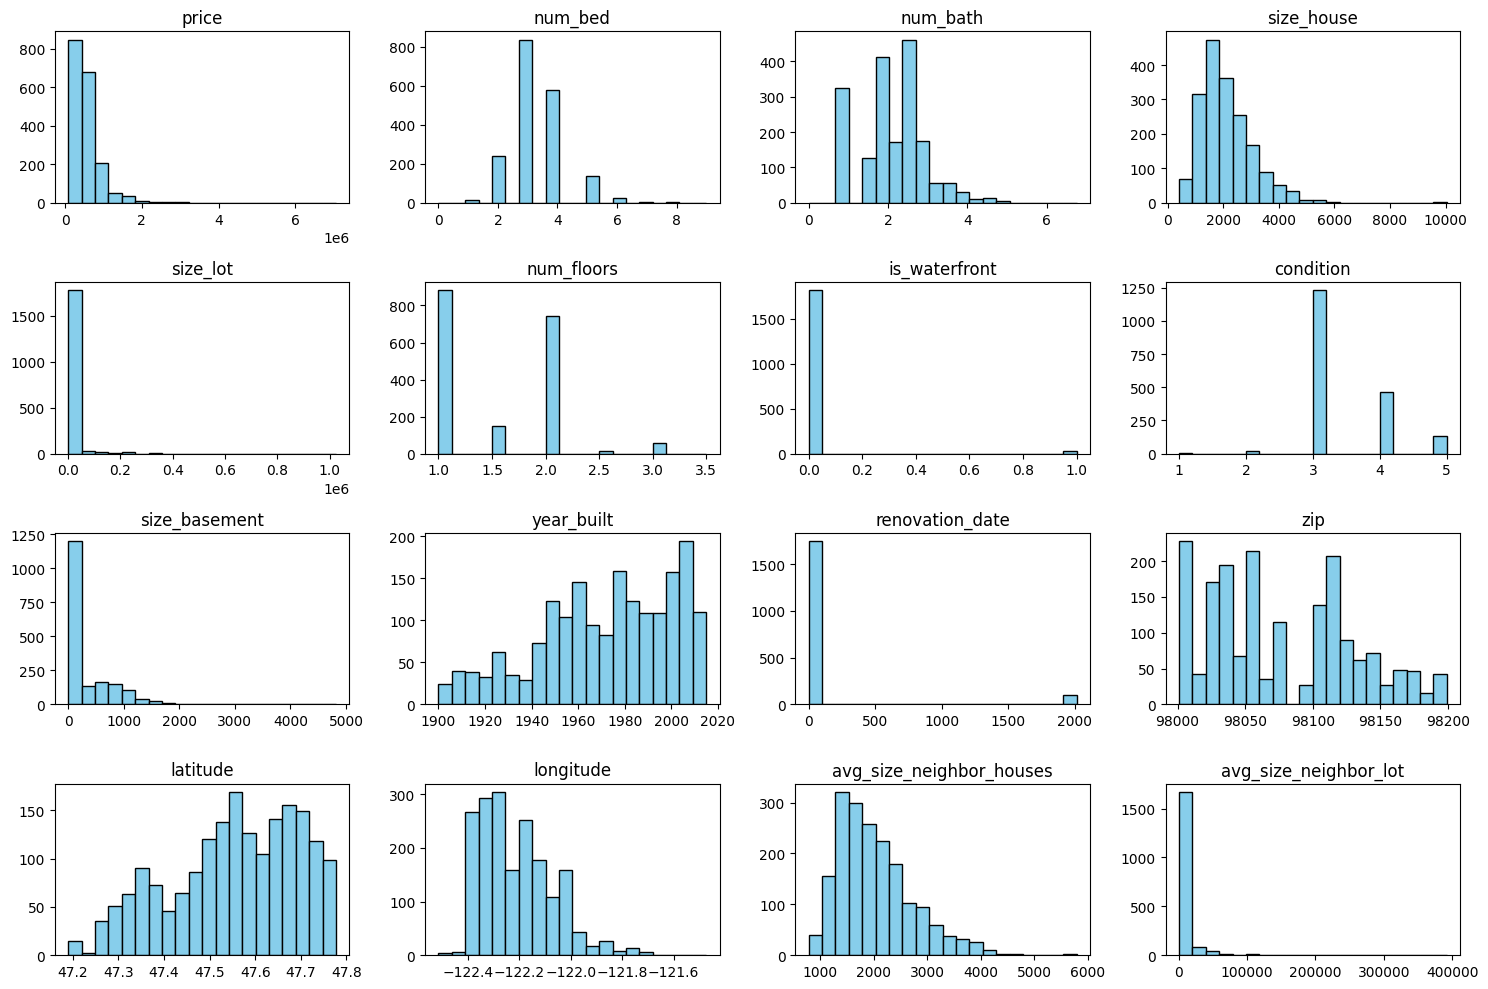

In [7]:
df.hist(figsize=(15,10), color='skyblue', edgecolor='black', bins=20, grid=False)
plt.tight_layout()
plt.show()

## Waterfront

In [8]:
round(df['is_waterfront'].value_counts(normalize=True) * 100,2)

0    98.59
1     1.41
Name: is_waterfront, dtype: float64

Only 1,41% of houses sold has a view to a waterfront

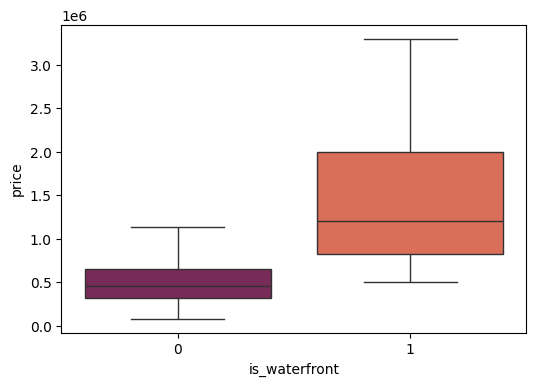

In [9]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x='is_waterfront', y='price', showfliers=False, palette="rocket")
plt.show()

### Student's T-test

Student's T-test for mean comparison

* Null Hypothesis (H0): There is no significant difference between the means.

* Alternative Hypothesis (H1): There is a significant difference between the means.

* p-value: expresses the risk of rejecting the null hypothesis when it is true.

* alpha (significance level): the maximum risk we are willing to assume in committing the Type I error (rejecting H0 when it is true).

In [10]:
is_waterfront_true_price = df[df['is_waterfront'].eq(1)]['price']
is_waterfront_false_price = df[df['is_waterfront'].eq(0)]['price']

In [11]:
stat, p = ttest_ind(is_waterfront_true_price, is_waterfront_false_price)

print('P-value: ', p)

if p > 0.05:
    print('There is no significant difference between the means.')
else:
    print('There is a significant difference between the means.')

P-value:  4.02713724854198e-53
There is a significant difference between the means.


## Renovation date

In [12]:
round(df['renovation_date'].value_counts(normalize=True) * 100,2).head(8)

0       94.58
2014     0.60
2003     0.33
2000     0.27
1985     0.27
2002     0.22
2013     0.22
1984     0.16
Name: renovation_date, dtype: float64

In [13]:
print('Year of the oldest renovation:', df[~df['renovation_date'].eq(0)]['renovation_date'].min())
print('Year of the newest renovation:', df[~df['renovation_date'].eq(0)]['renovation_date'].max())

Year of the oldest renovation: 1948
Year of the newest renovation: 2014


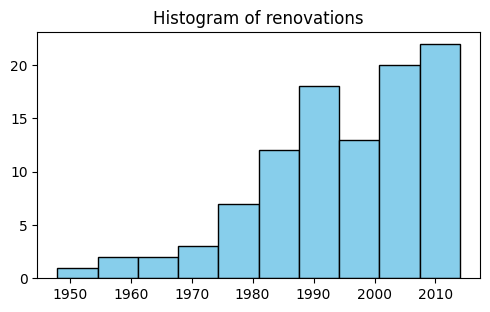

In [14]:
df[~df['renovation_date'].eq(0)]['renovation_date'].hist(figsize=(5,3), color='skyblue', edgecolor='black', grid=False)
plt.tight_layout()
plt.title('Histogram of renovations')
plt.show()

94.58% of the houses sold have never been renovated. Renovated houses represents 5.42% and the years range from 1948 to 2014.

## Number of floors

In [15]:
round(df['num_floors'].value_counts(normalize=True) * 100,2)

1.0    47.80
2.0    40.16
1.5     7.97
3.0     3.20
2.5     0.81
3.5     0.05
Name: num_floors, dtype: float64

Since there are decimal values for the num_floors feature, I will assume that these are penthouse apartments.

PENTHOUSE meaning: 1. an expensive apartment or set of rooms at the top of a hotel or tall building. Font: Cambridge Dictionary

## Condition

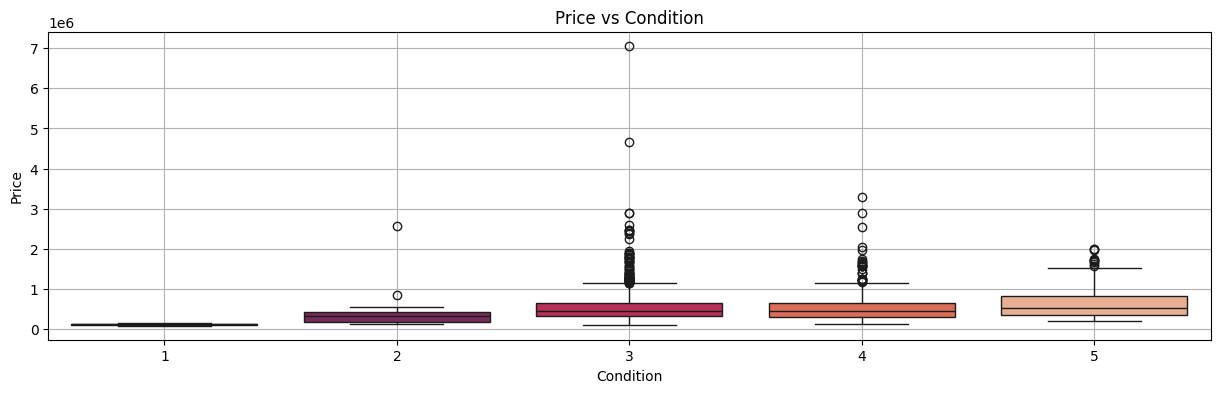

In [16]:
plt.figure(figsize=(15, 4))
sns.boxplot(x='condition', y='price', data=df, palette='rocket')
plt.title('Price vs Condition')
plt.xlabel('Condition')
plt.ylabel('Price')
plt.grid(True)
plt.show()

Condition is not necessarily the determinant of how expensive the house will be

## Size House

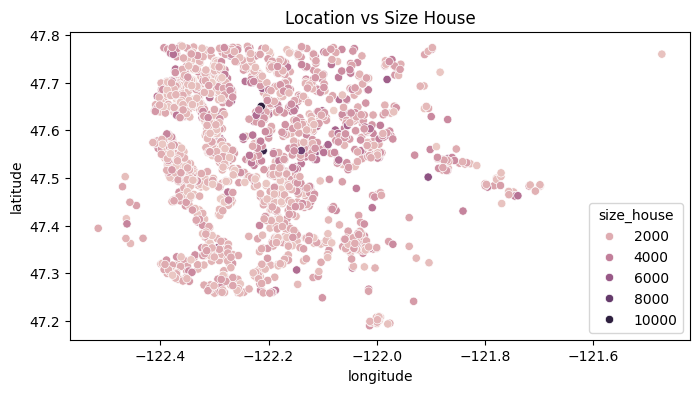

In [17]:
plt.figure(figsize=(8,4))
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=df['size_house'])
plt.title('Location vs Size House')
plt.show()

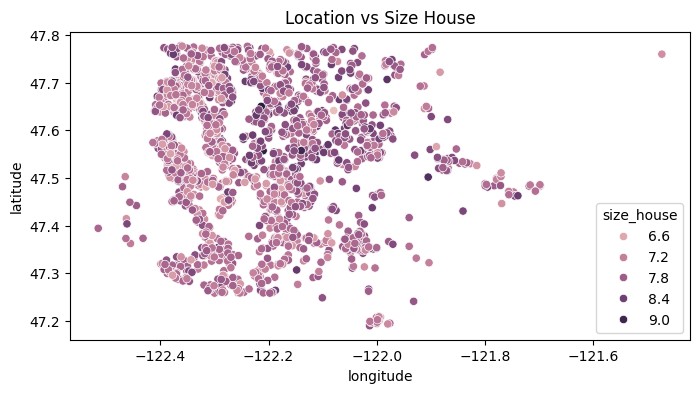

In [18]:
plt.figure(figsize=(8,4))
sns.scatterplot(x=df['longitude'], y=df['latitude'], hue=np.log(df['size_house']))
plt.title('Location vs Size House')
plt.show()

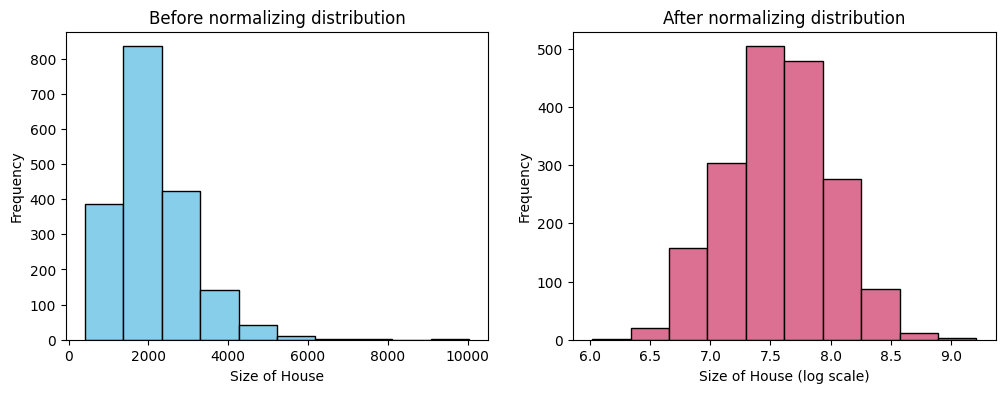

In [19]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

df['size_house'].plot(kind='hist', ax=axs[0], color='skyblue', edgecolor='black')
axs[0].set_title('Before normalizing distribution')
axs[0].set_xlabel('Size of House')

np.log(df['size_house']).plot(kind='hist', ax=axs[1], color='palevioletred', edgecolor='black')
axs[1].set_title('After normalizing distribution')
axs[1].set_xlabel('Size of House (log scale)')

plt.show()

Larger houses seem to be more located towards the center/north, coinciding with the size information.

In [20]:
f = folium.Figure(width=1200, height=600)
map = folium.Map(location= [47.518518, -122.224414], tiles="cartodbpositron",
                    zoom_start=10, min_zoom = 6).add_to(f)

heat_data = [[row['latitude'], row['longitude']] for index, row in df.iterrows()]
HeatMap(heat_data, name= 'Heat Map').add_to(map)

max_price_index = df['price'].idxmax()
max_price_location = [df.loc[max_price_index, 'latitude'], df.loc[max_price_index, 'longitude']]
folium.Marker(max_price_location, popup=f'Highest Price: ${df.loc[max_price_index, "price"]}',
              icon=folium.Icon(color='red', icon='info-sign')).add_to(map)

min_price_index = df['price'].idxmin()
min_price_location = [df.loc[min_price_index, 'latitude'], df.loc[min_price_index, 'longitude']]
popup_content_min = f'Lowest Price: ${df.loc[min_price_index, "price"]}'
folium.Marker(min_price_location, popup=popup_content_min,
              icon=folium.Icon(color='blue', icon='info-sign')).add_to(map)

folium.TileLayer('openstreetmap').add_to(map)
folium.TileLayer('cartodbpositron').add_to(map)
folium.LayerControl(collapsed=False).add_to(map)

map